In [1]:
import os
import copy

import numpy as np
import torch
import torch.nn as nn
import math

from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from unet import UNet
from dice_loss import dice_coeff
####################################################
# for data splitting
####################################################
import pandas as pd
####################################################
# for data preparation
####################################################
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score
####################################################
# for plotting
####################################################
import matplotlib.pyplot as plt
from IPython.display import clear_output
############################
# Helper func
############################
from helper import * 
###################################
TRAIN_RATIO = 0.8
RS = 30448
N_CHANNELS, N_CLASSES = 1, 1 
bilinear = True
BATCH_SIZE, EPOCHS = 16, 500
IMAGE_SIZE = (600, 600)
CROP_SIZE = (600, 600)

#########################################
DIR = 'data/'

print()

In [2]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [3]:
import os
from sklearn.model_selection import train_test_split

CLIENTS = ['miccai', 'bns']
CLIENTS_2 = [cl + '_2' for cl in CLIENTS]
###################################################################
TOTAL_CLIENTS = len(CLIENTS)

DIR_DATA = 'data/imagesTrAug/'
DIR_GT = 'data/labelsTrBW/'

# Costruire una lista dei nomi dei file per ciascun nuovo dataset.
skin_dataset = dict()
skin_dataset['miccai'] = ['miccai_{:03d}'.format(i) for i in range(201, 227)]  # Nomi dei file per il dataset "miccai"
skin_dataset['bns'] = ['bns_{:03d}'.format(i) for i in range(181, 204)]  # Nomi dei file per il dataset "bns"

split_dataset = dict()
STATIC_WEIGHT = [0, 0]
order = 0

for client in skin_dataset:
    tmp = skin_dataset[client]
    x_ = [os.path.join(DIR_DATA, f + '.png') for f in tmp]
    y_ = [os.path.join(DIR_GT, f + '.png') for f in tmp]
    
    x_train, x_test, y_train, y_test = train_test_split(
        x_, y_, test_size=1 - TRAIN_RATIO, random_state=RS)

    split_dataset[client + '_train'] = Cancer(x_train, y_train, train=True, \
                                              IMAGE_SIZE=IMAGE_SIZE \
                                              , CROP_SIZE=CROP_SIZE)
    STATIC_WEIGHT[order] = len(x_train)
    order += 1

    split_dataset[client + '_test'] = Cancer(x_test, y_test, train=False, \
                                             IMAGE_SIZE=IMAGE_SIZE \
                                             , CROP_SIZE=CROP_SIZE)
    print(client)


# Aggiungi le immagini rimanenti di Miccai al set di addestramento di Miccai
miccai_remaining = ['miccai_{:03d}'.format(i) for i in range(1, 201)]  # Immagini non ancora aggiunte
miccai_train = split_dataset['miccai_train'].data  # Percorsi delle immagini già nel set di addestramento di Miccai
miccai_remaining = [os.path.join(DIR_DATA, f + '.png') for f in miccai_remaining if f not in miccai_train]
split_dataset['miccai_train'].data.extend(miccai_remaining)

# Aggiungi le immagini rimanenti di Bns al set di addestramento di Bns
bns_remaining = ['bns_{:03d}'.format(i) for i in range(1, 181)]  # Immagini non ancora aggiunte
bns_train = split_dataset['bns_train'].data  # Percorsi delle immagini già nel set di addestramento di Bns
bns_remaining = [os.path.join(DIR_DATA, f + '.png') for f in bns_remaining if f not in bns_train]
split_dataset['bns_train'].data.extend(bns_remaining)


miccai
bns


In [4]:
STATIC_WEIGHT = [item / sum(STATIC_WEIGHT) for item in STATIC_WEIGHT]
print(STATIC_WEIGHT)

[0.5263157894736842, 0.47368421052631576]


In [5]:
device = torch.device('cuda:0')
LR, WD, TH = 1e-3, 1e-4, 0.9
best_avg_acc, best_epoch = 0.0, 0

In [6]:
training_clients, testing_clients = dict(), dict()
training_clients_pl = dict()

acc_train, acc_test, loss_train, loss_test = dict(), dict(), \
                                            dict(), dict()
    
nets, optimizers = dict(), dict()

nets['global'] = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, \
                      bilinear=True).to(device)

nets['global_2'] = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, \
                      bilinear=True).to(device)

for client in CLIENTS:
    print(client)
    training_clients[client] = DataLoader(split_dataset[client+'_train'], batch_size=4,\
                 shuffle=True, num_workers=8)
    training_clients_pl[client] = DataLoader(split_dataset[client+'_train'], batch_size=1, \
                shuffle=True, num_workers=8)
    ###################################################################################
    testing_clients[client] = DataLoader(split_dataset[client+'_test'], batch_size=1,\
                         shuffle=False, num_workers=1)
    
    acc_train[client], acc_test[client] = [], []
    loss_train[client], loss_test[client] = [], []
        
    nets[client] = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, \
                      bilinear=True).to(device)
    nets[client+'_2'] = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, \
                      bilinear=True).to(device)
    optimizers[client]= optim.Adam(nets[client].parameters(), \
                                   lr=LR,weight_decay=WD)
    optimizers[client+'_2']= optim.Adam(nets[client+'_2'].parameters(), \
                                   lr=LR,weight_decay=WD)

miccai
bns


# FedST or FedRGD

In [7]:
WEIGHTS_POSTWARMUP = [0.1/3, 0.1/3] #put more weight to client with strong supervision
WARMUP_EPOCH = 150
CLIENTS_SUPERVISION = ['labeled', 'labeled']


# MODE = 'FedST' 
MODE = 'FedRGD'

CE_ = nn.BCELoss()
WEIGHTS = [0.0, 0.0]

if MODE == 'FedST':
    WEIGHTS_POSTWARMUP = [0.1/3, 0.1/3] #put more weight to client with strong supervision
else:
    WEIGHTS_POSTWARMUP = [0.5/3, 0.5/3] #random client, but effectively, put 1/2 trust to strongly supervised client

# first 150 epochs warmup by training locally on labeled clients, vienna dias

2 7.998195309758907e-09 7.998195309758907e-09


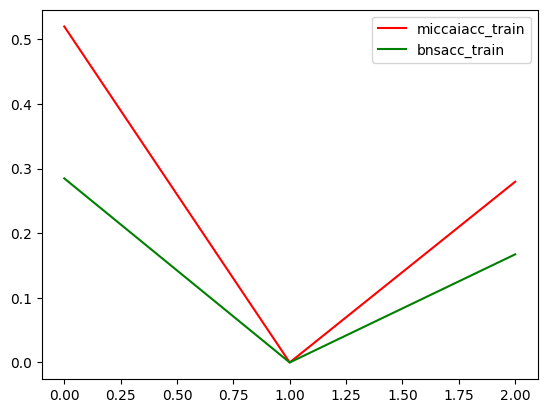

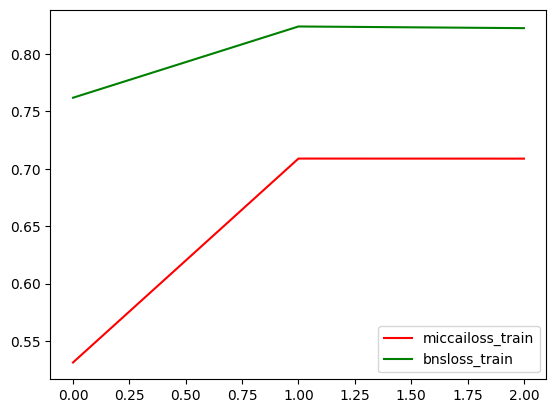

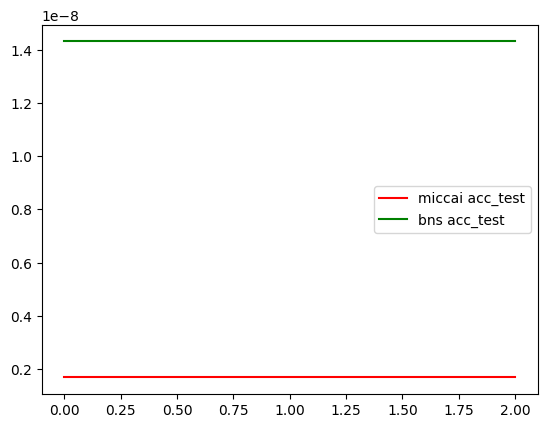

In [ ]:
best_avg_acc, best_epoch_avg = 0,0
index = []
best_model_dir = "./"
best_avg_acc, best_epoch_avg = 0, 0
best_models = {}  # Dizionario per memorizzare i migliori modelli per ciascun cliente

for client in CLIENTS:
    acc_train[client], acc_test[client] = [], []
    loss_train[client], loss_test[client] = [], []

USE_UNLABELED_CLIENT = False
for epoch in range(EPOCHS):
    if epoch == WARMUP_EPOCH:
        WEIGHTS = WEIGHTS_POSTWARMUP
        USE_UNLABELED_CLIENT = True
        
    index.append(epoch)
    
    #################### copy fed model ###################
    copy_fed(CLIENTS, nets, fed_name='global')
    
    #### conduct training #####
    for client, supervision_t in zip(CLIENTS, CLIENTS_SUPERVISION):
        if supervision_t == 'unlabeled':
            if not USE_UNLABELED_CLIENT:
                acc_train[client].append(0)
                loss_train[client].append(0)
                continue
        
        train_model(training_clients[client], nets[client], \
                                  optimizers[client], device, \
                                  acc = acc_train[client], \
                                  loss = loss_train[client], \
                                  supervision_type = supervision_t, \
                                 warmup=True, CE_LOSS = CE_)
        
    aggr_fed(CLIENTS, WEIGHTS, nets)
    ################### test ##############################
    avg_acc = 0.0
    for client in CLIENTS:
        test(epoch, testing_clients[client], nets['global'], device, acc_test[client],\
             loss_test[client])
        avg_acc += acc_test[client][-1]
        # Salva il modello se l'accuratezza del cliente migliora
        if acc_test[client][-1] > best_models.get(client, {'accuracy': 0})['accuracy']:
            best_models[client] = {'model': nets[client].state_dict(), 'accuracy': acc_test[client][-1]}
            torch.save(nets[client].state_dict(), os.path.join(best_model_dir, f"best_model_{client}.pt"))
            
    avg_acc = avg_acc / TOTAL_CLIENTS
    ############################################################
    ########################################################
    if avg_acc > best_avg_acc:
        best_avg_acc = avg_acc
        best_epoch = epoch
        # Salvataggio del modello federato contenente tutte le reti
        torch.save(nets['global'].state_dict(), os.path.join(best_model_dir, f"best_fed_model.pt"))
    ################################
    # plot #########################
    ################################
    clear_output(wait=True)
    print(epoch, avg_acc, best_avg_acc)
    plot_graphs(0, CLIENTS, index, acc_train, 'acc_train')
    plot_graphs(1, CLIENTS, index, loss_train, 'loss_train')
    plot_graphs(2, CLIENTS, index, acc_test, ' acc_test')

print(best_avg_acc, best_epoch)
for client in CLIENTS:
    print(client)
    tmp = best_epoch
    best_epoch = best_epoch 
    print("shared epoch specific")
    print(acc_test[client][best_epoch])
    print("max client-specific")
    print(np.max(acc_test[client]))
    best_epoch = tmp